In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.externals import joblib
from calc_ledd import calc_ledd

In [3]:
path = ### PUT PATH TO DATA HERE ###

In [4]:
# import processed data, note that these csv's are generated by 'Full_Data_Processing.ipynb'
pd_data = pd.read_csv('pd_on.csv')
hc_data = pd.read_csv('hc.csv')

In [5]:
# import train/test split, note that this is generated by 'Train_Test_Split.ipynb'
with open('train_test_split.pkl', 'rb') as handle:
    pids = pickle.load(handle)

In [6]:
train_ids = pids['train_ids'] #PATNO's for training
test_ids = pids['test_ids'] #PATNO's for testing

train = pd_data[(pd_data.PATNO.isin(train_ids))].reset_index() #training data
test = pd_data[(pd_data.PATNO.isin(test_ids))].reset_index() #testing data

In [7]:
# import lower dimensional (LD) data, note that this is generated by 'Learn_and_Apply_cLVM.ipynb'
# note that parameters are the same in each pkl
clvm_train = joblib.load('cLVM_model9iter14999.pkl')
clvm_test = joblib.load('cLVM_model_test9iter14999.pkl')
    
w = clvm_train['W']
s = clvm_train['S']

x_train = clvm_train['zi']
x_test = clvm_test['zi']

# model doesn't automatically sort by decreasing variance, do it manually here
order_w = np.argsort(np.linalg.norm(w, axis=1))
order_w = np.flipud(order_w)

#re-arrange z_post based on w and trim to 28 based on ARD results
x_train = x_train[:,order_w][:,:28]
x_test = x_test[:, order_w][:,:28]

In [8]:
# link patient number and event ID to lower dimensional data
df_train = train[['PATNO', 'EVENT_ID', 'INFODT']].join(pd.DataFrame(x_train))
df_test = test[['PATNO', 'EVENT_ID', 'INFODT']].join(pd.DataFrame(x_test))

In [9]:
# import medication information
ledd = pd.read_csv('ledd.csv')
ledd = ledd.drop(columns='Unnamed: 0')

In [10]:
# merge medication information
df_train = df_train.merge(ledd, how='left', on=['PATNO', 'EVENT_ID', 'INFODT'])
df_test = df_test.merge(ledd, how='left', on=['PATNO', 'EVENT_ID', 'INFODT'])

In [11]:
# reshape data frame such that it is n patients x t time points x d dimensions
train_grid = np.nan*np.ones((len(train_ids), 31, 28))
test_grid = np.nan*np.ones((len(test_ids), 31, 28))

train_med_grid = np.nan*np.ones((len(train_ids), 31))
test_med_grid = np.nan*np.ones((len(test_ids), 31))

train_pat = np.zeros(len(train_ids))
test_pat = np.zeros(len(test_ids))

In [12]:
# import conncomitant medications file to confirm if a patient is still prescribed a medication
con_med = pd.read_csv(path + 'Concomitant_Medications.csv')

In [13]:
con_med = con_med[(con_med.DISMED==1) | ((con_med.DISMED.isnull()) & (~con_med.LEDD.isnull()))]

In [14]:
cm_train = con_med[con_med.PATNO.isin(train_ids)]
cm_test = con_med[con_med.PATNO.isin(test_ids)]

In [15]:
cm_train.STARTDT = pd.to_datetime(cm_train.STARTDT)
cm_train.STOPDT = pd.to_datetime(cm_train.STOPDT)

cm_test.STARTDT = pd.to_datetime(cm_test.STARTDT)
cm_test.STOPDT = pd.to_datetime(cm_test.STOPDT)

In [16]:
count = 0
for i, pid in enumerate(train_ids):
    # model uses a 3-month time step so we can't include SC and BL visits, drop SC
    df = df_train[df_train.PATNO==pid].drop(labels=df_train[(df_train.PATNO==pid) & (df_train.EVENT_ID=='SC')].index)
    
    dt = pd.to_datetime(df.iloc[:,2]).values - pd.to_datetime(df[df.EVENT_ID=='BL'].iloc[:,2]).values
    dt = dt/pd.Timedelta(1,'D')/365.4*12 # time in months
    
    t_idx = np.argsort(dt)
    
    store_idx = np.round(dt/3).astype(int)[t_idx] # index of closest 3-month interval
    rec = df.iloc[:,3:-1].values[t_idx] # clinical data
    med = df.iloc[:,-1].values[t_idx] # medication data
    
    if len(np.unique(store_idx)) != len(store_idx):
        # if two records are overlapping, move the second one to the next interval
        dup_idx = np.where(np.diff(store_idx) == 0)[0][:].astype(int)
        #print('PATNO:', pid, 'index:', i)
        #print('dup_idx:', dup_idx)
        count = count + 1
        store_idx[dup_idx+1] = store_idx[dup_idx+1] +1
        
    train_grid[i, store_idx, :] = rec
    train_med_grid[i, store_idx] = med
    train_pat[i] = pid
    
    # 'fill-in' medication information even when a patient doesn't have a visit based on information from the concomitant_medications data
    for j in range(store_idx[-1]):
        if np.isnan(train_med_grid[i,j]):
            med_time = pd.to_datetime(df.iloc[:,2].values[t_idx[0]]) + pd.Timedelta(90*j,'D')
            train_med_grid[i,j] = calc_ledd(cm_train, pid, med_time)

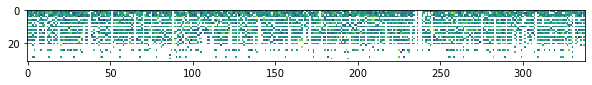

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(train_grid[:,:,0].T)

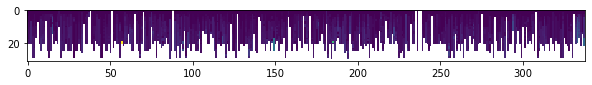

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(train_med_grid.T)

In [19]:
count = 0
for i, pid in enumerate(test_ids):
    # model uses a 3-month time step so we can't include SC and BL visits, drop SC
    df = df_test[df_test.PATNO==pid].drop(labels=df_test[(df_test.PATNO==pid) & (df_test.EVENT_ID=='SC')].index)
    
    dt = pd.to_datetime(df.iloc[:,2]).values - pd.to_datetime(df[df.EVENT_ID=='BL'].iloc[:,2]).values
    dt = dt/pd.Timedelta(1,'D')/365.4*12 # time in months
    
    t_idx = np.argsort(dt)
    
    store_idx = np.round(dt/3).astype(int)[t_idx] # index of closest 3-month interval
    rec = df.iloc[:,3:-1].values[t_idx] #clinical data
    med = df.iloc[:,-1].values[t_idx] #medication data
    
    if len(np.unique(store_idx)) != len(store_idx):
        # if two records are overlapping, move the second one to the next intervla
        dup_idx = np.where(np.diff(store_idx) == 0)[0][:].astype(int)
        #print('PATNO:', pid, 'index:', i)
        #print('dup_idx:', dup_idx)
        count = count + 1
        store_idx[dup_idx+1] = store_idx[dup_idx+1] +1
        
    test_grid[i, store_idx, :] = rec
    test_med_grid[i, store_idx] = med
    test_pat[i] = pid
    
    for j in range(store_idx[-1]):
        if np.isnan(test_med_grid[i,j]):
            med_time = pd.to_datetime(df.iloc[:,2].values[t_idx[0]]) + pd.Timedelta(90*j,'D')
            test_med_grid[i,j] = calc_ledd(cm_test, pid, med_time)
    

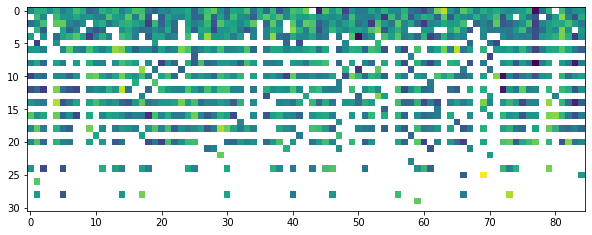

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(test_grid[:,:,0].T)

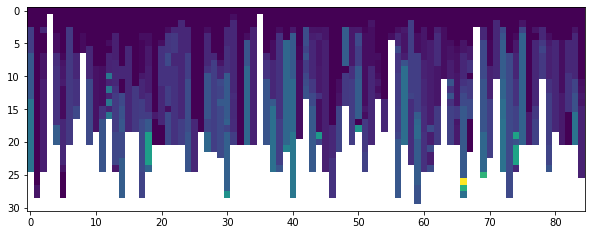

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(test_med_grid.T)

In [22]:
data_for_PIOHMM = {'train_patno': train_pat, 'test_patno': test_pat, 'x_train': train_grid, 'x_test': test_grid,
                  'train_med': train_med_grid, 'test_med': test_med_grid}

In [23]:
with open('data_for_PIOHMM.pkl', 'wb') as handle:
    pickle.dump(data_for_PIOHMM, handle)